In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm
import random

In [3]:
words = list(open('names.txt', 'r').read().splitlines())

In [4]:
letters = sorted(list(set(''.join(words))))
ltoi = {l: i+1 for i, l in enumerate(letters)}
ltoi["."] = 0
itol = {i:l for l, i in ltoi.items()}

In [90]:
block_size = 3
dim_size = 2

X = []
Y = []
for w in words:
    context = [0]*block_size
    for char in w:
        ix = ltoi[char]
        X.append(context)
        Y.append(ltoi[char])
        context = context[1:] + [ltoi[char]]
X = torch.tensor(X)
Y = torch.tensor(Y)
len(Y)

196113

In [91]:
X.shape, Y.shape

(torch.Size([196113, 3]), torch.Size([196113]))

In [108]:
C = torch.randn(27,dim_size)
W = torch.randn(dim_size * block_size, 100)
b = torch.randn(100)
W2 = torch.randn(100, 27)
b2 = torch.randn(27)
params = [C, W, b, W2, b2]
print("amout of paramas: ", sum(p.numel() for p in parmas))
for p in params:
    p.requires_grad = True

amout of paramas:  3481


In [109]:
stepi = []
lossi = []
count = 0

In [114]:
for i in range(10_000):
    ix = torch.randint(0, X.shape[0], (32,))
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W + b)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    for p in params:
        p.grad = None
    loss.backward()
    for p in params:
        p.data -= 0.01 * p.grad
    stepi.append(count)
    count += 1
    lossi.append(loss.item())
print(loss.item())


2.8190181255340576


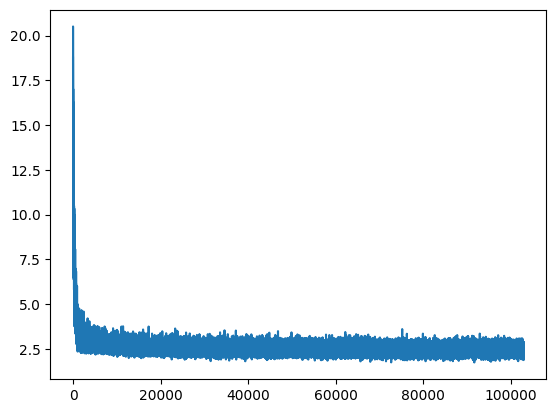

In [115]:
plt.plot(stepi, lossi)

### everything together

In [ ]:
words = list(open('names.txt', 'r').read().splitlines())
letters = sorted(list(set(''.join(words))))
ltoi = {l: i+1 for i, l in enumerate(letters)}
ltoi["."] = 0
itol = {i:l for l, i in ltoi.items()}

In [45]:

initialize = True
if initialize:
    loop = []
    loss_decay = []
    lossltr = []
    losslval = []
def build_dataset(words, block_size=3):
    X = []
    Y = []
    for w in words:
        context = [0]*block_size
        for char in w + ".":
            X.append(context)
            Y.append(ltoi[char])
            context = context[1:] + [ltoi[char]]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

for k in range(1):
    batch_size = 32
    if initialize:
        #hyper parameters:
        block_size = 3
        dim_size = 10
        middle_layer = 300
        loop.append(k)

        random.shuffle(words)
        n1 = int(len(words)*0.8)
        n2 = int(len(words)*0.9)
        Xtr, Ytr = build_dataset(words[:n1], block_size)
        Xval, Yval = build_dataset(words[n1:n2], block_size)
        Xtest, Ytest = build_dataset(words[n2:], block_size)

   
        C = torch.randn(27,dim_size)
        W = torch.randn(dim_size * block_size, middle_layer)
        b = torch.randn(middle_layer)
        W2 = torch.randn(middle_layer, 27)
        b2 = torch.randn(27)
        params = [C, W, b, W2, b2]
        for p in params:
            p.requires_grad = True
    reps = int(500_000)
    current_loss = []
    for i in tqdm(range(reps)):
        ix = torch.randint(0, Xtr.shape[0], (batch_size,))
        emb = C[Xtr[ix]]
        h = torch.tanh(emb.view(-1, block_size*dim_size) @ W + b)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Ytr[ix])
        for p in params:
            p.grad = None
        loss.backward()
        step_size = 0.1 if i < 0.7*reps else 0.01 if i < 0.9*reps else 0.001
        for p in params:
            p.data -= step_size * p.grad
        current_loss.append([i, loss.item()])
    loss_decay.append(current_loss)
    #calc loss
    emb = C[Xtr]
    h = torch.tanh(emb.view(-1, block_size * dim_size) @ W + b)
    logits = h @ W2 + b2
    loss_tr = F.cross_entropy(logits, Ytr)
    lossltr.append(loss_tr.item())

    emb = C[Xval]
    h = torch.tanh(emb.view(-1, block_size * dim_size) @ W + b)
    logits = h @ W2 + b2
    loss_val = F.cross_entropy(logits, Yval)
    losslval.append(loss_val.item())
    print(f"loss train = {loss_tr}, loss val = {loss_val}")

100%|██████████| 500000/500000 [05:29<00:00, 1517.13it/s]


loss train = 2.006357431411743, loss val = 2.1145544052124023


In [46]:
xs = [x[0] for x in loss_decay[0]]
ys = [y[1] for y in loss_decay[0]]

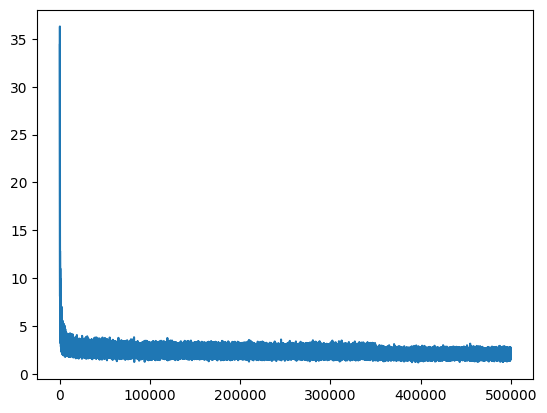

In [47]:
plt.plot(xs, ys)

In [48]:
block_size = 3
dim_size = 10

emb = C[Xtest]
h = torch.tanh(emb.view(-1, block_size * dim_size) @ W + b)
logits = h @ W2 + b2
loss_tr = F.cross_entropy(logits, Ytest)

print(loss.item())

1.668571949005127


In [49]:
emb = C[torch.tensor([0,0,0])]
print(emb.view(-1, block_size * dim_size).shape)
print(W.shape)
h = torch.tanh(emb.view(-1, block_size * dim_size) @ W + b)
logits = h @ W2 + b2
F.softmax(logits, dim=1)

torch.Size([1, 30])
torch.Size([30, 300])


tensor([[0.0001, 0.1319, 0.0383, 0.0474, 0.0485, 0.0438, 0.0120, 0.0208, 0.0254,
         0.0177, 0.0852, 0.0856, 0.0517, 0.0863, 0.0358, 0.0134, 0.0155, 0.0027,
         0.0617, 0.0620, 0.0421, 0.0023, 0.0131, 0.0082, 0.0044, 0.0162, 0.0279]],
       grad_fn=<SoftmaxBackward0>)

In [52]:
for i in range(10):
    out = []
    context = [0] * 3 
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(-1, block_size * dim_size) @ W + b)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        out.append(ix)
        context = context[1:] + [ix]
        if not ix:
            break

    print("".join(itol[i] for i in out))

ana.
alor.
alaiyaheadelyn.
leeshangelili.
jahba.
phyle.
lai.
tre.
ter.
kaiah.


In [51]:
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W + b)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itol[i] for i in out))

alina.
evalesserian.
racii.
luis.
amichet.
keskott.
jayce.
ruda.
malie.
breckressii.
nuinsed.
ven.
elilanna.
adesey.
sunne.
kiplesa.
marionnessi.
ily.
rhamoneyton.
rhenroy.
